## Task 2 - Simple Outlier Detection

**Outlier:**   
* data point is not in alignment with the rest of the series    

  
**Goal:**     
* segregate the outliers    
* calculate moving average - outlier if it is more than 1.5 standard deviations apart from its calculated moving average  

  
**Outcome:**   
* plot & highlights all found outliers

---

In [93]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style("whitegrid")

import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

---

### Loading data

In [3]:
dfc = pd.read_parquet('ctr.parquet', engine='pyarrow')
dfc['date_hour'] = pd.to_datetime(dfc['date_hour'])
dfc = dfc.set_index(['date_hour'])
dfc = dfc[['CTR']]

dfc.head(3)

,CTR
date_hour,
2014-01-21 00:10:00,17.47
2014-01-21 01:10:00,17.37
2014-01-21 02:10:00,15.07


### Plot CTR

In [26]:
fig = px.line(dfc.reset_index(), x="date_hour", y="CTR", title='CTR by hour')
fig.show()

### Analysis

### Stationarity

rolling average and the rolling standard deviation of time series do not change over time

#### Dickey-Fuller Test

In [10]:
af = adfuller(dfc['CTR'], autolag='AIC')
pd.DataFrame([list(af[0:4]) + list(af[4].values())], 
             columns=['Test Statistic','p-value','#Lags Used','Number of Observations Used'] + list(af[4].keys()))

,Test Statistic,p-value,#Lags Used,Number of Observations Used,1%,5%,10%
0,-6.646502,5.249402e-09,1,238,-3.458128,-2.873762,-2.573283


$H_0$: There's an unit root for the series   
$H_1$: There's no unit root for the series. The series is stationary   

Test statistic is smaller than critical value, which implies that the series is stationary. We fail to reject $H_0$.   

Based on the task we assume Gaussian distribution. Gaussian distribution indicates stationarity.  

Reasons behind non-stationarity can be:  
* trend    
* seasonality   

### Sesonality

* trend
* seasonality
* noise
    
     
* additive model: seasonal variation is constant (Level + Trend + Seasonality + Noise)           
* multiplicative model: seasonal variation increases (Level * Trend * Seasonality * Noise)         
  
    
*-> additive model is used*

#### Decomposition

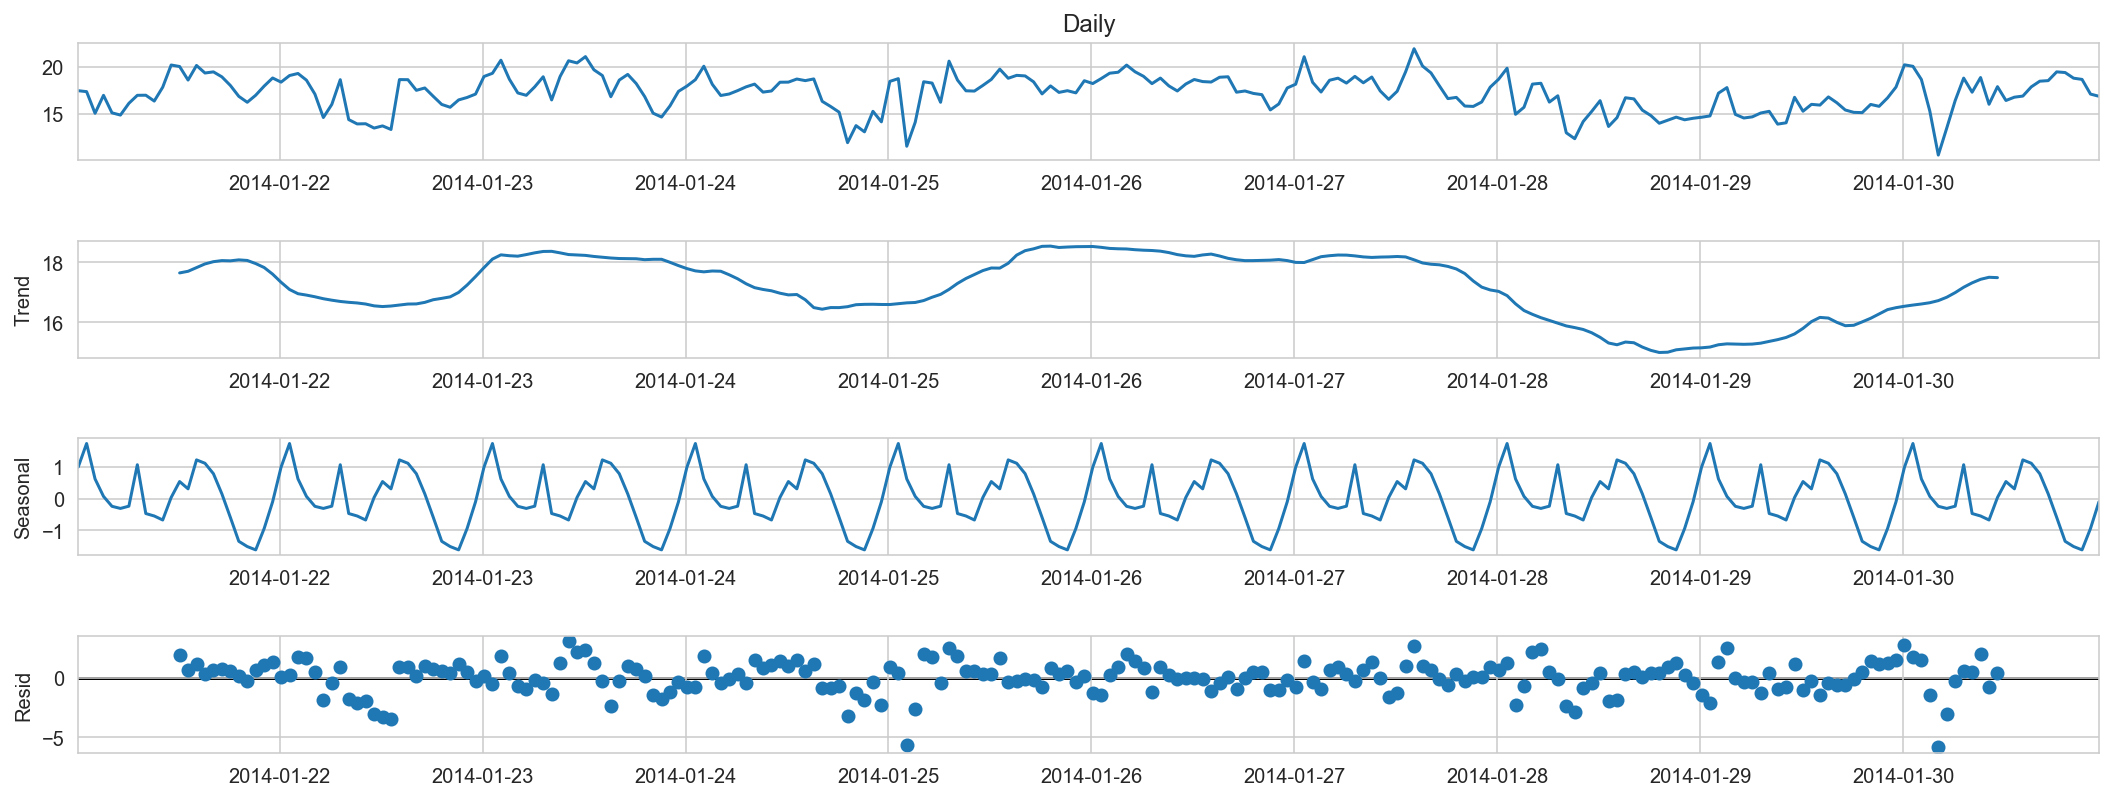

In [30]:
res = seasonal_decompose(dfc['CTR'], period=24,
                       model='additive')

fig = res.plot()
fig.get_axes()[0].set_title('Daily')

fig.set_size_inches(16,6)

plt.show()

### Moving Average

* exponential moving average (equal weighted)  
* simple moving average (more weight to recent data)     

#### Simple Moving Average

* previous hours (based on the window size) are considered to be the expected value in the present hour    
* Then checking whether an estimated value is within the predefined band

In [35]:
def simple_moving_avg(df, window, std):
    rolling_mean = df['CTR'].rolling(window).mean()
    rolling_std = df['CTR'].rolling(window).std()
    
    h = 'SMA_High_{}'.format(window)
    lw = 'SMA_Low_{}'.format(window)
    df[h] = rolling_mean + (rolling_std * std)
    df[lw] = rolling_mean - (rolling_std * std)  

In [36]:
window = 6 # 6 hours
simple_moving_avg(dfc, window, 1.5)

window = 12 # 12 hours
simple_moving_avg(dfc, window, 1.5)

window = 24 # 1 day
simple_moving_avg(dfc, window, 1.5)

In [43]:
dfc.head(10)

,CTR,SMA_High_24,SMA_Low_24,SMA_High_12,SMA_Low_12,SMA_High_6,SMA_Low_6
date_hour,,,,,,,
2014-01-21 00:10:00,17.47,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-21 01:10:00,17.37,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-21 02:10:00,15.07,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-21 03:10:00,16.98,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-21 04:10:00,15.12,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-21 05:10:00,14.88,NaN,NaN,NaN,NaN,18.017009,14.279658
2014-01-21 06:10:00,16.13,NaN,NaN,NaN,NaN,17.528548,14.321452
2014-01-21 07:10:00,16.98,NaN,NaN,NaN,NaN,17.316437,14.403563
2014-01-21 08:10:00,16.99,NaN,NaN,NaN,NaN,17.642358,14.717642


In [62]:
# window = 24
dfc_sma_24 = dfc[['CTR', 'SMA_High_24', 'SMA_Low_24']]
x_axis = dfc_sma_24.index
y_axis_1 = dfc_sma_24.CTR
y_axis_2 = dfc_sma_24.SMA_High_24
y_axis_3 = dfc_sma_24.SMA_Low_24

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_1,
                    mode='lines',
                    name='CTR'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_2,
                    mode='markers',
                    name='SMA_High_24'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_3,
                    mode='markers', name='SMA_Low_24'))

fig.update_layout(title="Simple Moving Average window=24")

fig.show()

In [63]:
# window = 12
dfc_sma_12 = dfc[['CTR', 'SMA_High_12', 'SMA_Low_12']]
x_axis = dfc_sma_12.index
y_axis_1 = dfc_sma_12.CTR
y_axis_2 = dfc_sma_12.SMA_High_12
y_axis_3 = dfc_sma_12.SMA_Low_12

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_1,
                    mode='lines',
                    name='CTR'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_2,
                    mode='markers',
                    name='SMA_High_12'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_3,
                    mode='markers', name='SMA_Low_12'))

fig.update_layout(title="Simple Moving Average window=12")

fig.show()

In [64]:
# window = 6
dfc_sma_6 = dfc[['CTR', 'SMA_High_6', 'SMA_Low_6']]
x_axis = dfc_sma_6.index
y_axis_1 = dfc_sma_6.CTR
y_axis_2 = dfc_sma_6.SMA_High_6
y_axis_3 = dfc_sma_6.SMA_Low_6

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_1,
                    mode='lines',
                    name='CTR'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_2,
                    mode='markers',
                    name='SMA_High_6'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_3,
                    mode='markers', name='SMA_Low_6'))

fig.update_layout(title="Simple Moving Average window=6")

fig.show()

#### Exponentially Weighted Moving Average

In [44]:
def simple_moving_avg(df, span, std):
    ewm_mean = df['CTR'].ewm(span).mean()
    ewm_std = df['CTR'].ewm(span).std()
    
    h = 'WMA_High_{}'.format(window)
    lw = 'WMA_Low_{}'.format(window)
    df[h] = ewm_mean + (ewm_std * std)
    df[lw] = ewm_mean - (ewm_std * std)  

In [45]:
window = 6
simple_moving_avg(dfc, window, 1.5)

window = 12
simple_moving_avg(dfc, window, 1.5)

window = 24
simple_moving_avg(dfc, window, 1.5)

In [100]:
# window = 6
dfc_ewm_6 = dfc[['CTR', 'WMA_High_6', 'WMA_Low_6']]
x_axis = dfc_ewm_6.index
y_axis_1 = dfc_ewm_6.CTR
y_axis_2 = dfc_ewm_6.WMA_High_6
y_axis_3 = dfc_ewm_6.WMA_Low_6

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_1,
                    mode='lines',
                    name='CTR'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_2,
                    mode='markers',
                    name='WMA_High_6'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_3,
                    mode='markers', name='WMA_Low_6'))

fig.update_layout(title="Weighted Moving Average window=6")

fig.show()

In [101]:
# window = 12
dfc_ewm_12 = dfc[['CTR', 'WMA_High_12', 'WMA_Low_12']]
x_axis = dfc_ewm_12.index
y_axis_1 = dfc_ewm_12.CTR
y_axis_2 = dfc_ewm_12.WMA_High_12
y_axis_3 = dfc_ewm_12.WMA_Low_12

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_1,
                    mode='lines',
                    name='CTR'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_2,
                    mode='markers',
                    name='WMA_High_12'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_3,
                    mode='markers', name='WMA_Low_12'))

fig.update_layout(title="Weighted Moving Average window=12")

fig.show()

In [102]:
# window = 24
dfc_ewm_24 = dfc[['CTR', 'WMA_High_24', 'WMA_Low_24']]
x_axis = dfc_ewm_24.index
y_axis_1 = dfc_ewm_24.CTR
y_axis_2 = dfc_ewm_24.WMA_High_24
y_axis_3 = dfc_ewm_24.WMA_Low_24

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_1,
                    mode='lines',
                    name='CTR'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_2,
                    mode='markers',
                    name='WMA_High_24'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_3,
                    mode='markers', name='WMA_Low_24'))

fig.update_layout(title="Weighted Moving Average window=24")

fig.show()

----

### Outcome    
    
    
* Based on the requirements we identify a point as *outlier, if it is more than 1.5 standard deviations apart from its calculated moving average*   
* **effective window size**: we discovered daily pattern. -> *window size = 24*  

#### Simple Moving Average window size = 24

In [94]:
# window = 24, identify points
dfc_sma_high_24 = dfc[['CTR','SMA_High_24']]
dfc_sma_high_24['outliers_highlight'] = np.where(dfc_sma_high_24.CTR>dfc_sma_high_24.SMA_High_24, True, False)
dfc_sma_high_24['outliers'] = np.where(dfc_sma_high_24.CTR>dfc_sma_high_24.SMA_High_24, dfc_sma_high_24.CTR, np.nan)
dfc_sma_high_24[dfc_sma_high_24.outliers_highlight==True][:3]

,CTR,SMA_High_24,outliers_highlight,outliers
date_hour,,,,
2014-01-23 02:10:00,20.71,19.756325,True,20.71
2014-01-23 10:10:00,20.65,20.343617,True,20.65
2014-01-23 12:10:00,21.09,20.704626,True,21.09


In [103]:
# plot
# window = 24
x_axis = dfc_sma_high_24.index
y_axis_1 = dfc_sma_high_24.CTR
y_axis_2 = dfc_sma_high_24.SMA_High_24
y_axis_3 = dfc_sma_high_24.outliers

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_1,
                    mode='lines',
                    name='CTR'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_2,
                    mode='lines+markers',
                    name='Simple moving average >1.5 std'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_3,
                    mode='markers+text', name='outliers', text='o'))

fig.update_layout(title="Simple Moving Average window=24 - outliers")

fig.show()

#### Exponentially Weighted Moving Average

In [104]:
# window = 24, identify points
dfc_wma_high_24 = dfc[['CTR','WMA_High_24']]
dfc_wma_high_24['outliers_highlight'] = np.where(dfc_wma_high_24.CTR>dfc_wma_high_24.WMA_High_24, True, False)
dfc_wma_high_24['outliers'] = np.where(dfc_wma_high_24.CTR>dfc_wma_high_24.WMA_High_24, dfc_wma_high_24.CTR, np.nan)
dfc_wma_high_24[dfc_wma_high_24.outliers_highlight==True][:3]

,CTR,WMA_High_24,outliers_highlight,outliers
date_hour,,,,
2014-01-21 11:10:00,20.20,19.172557,True,20.20
2014-01-21 12:10:00,20.04,19.804888,True,20.04
2014-01-23 02:10:00,20.71,20.193221,True,20.71


In [105]:
# plot
# window = 24
x_axis = dfc_wma_high_24.index
y_axis_1 = dfc_wma_high_24.CTR
y_axis_2 = dfc_wma_high_24.WMA_High_24
y_axis_3 = dfc_wma_high_24.outliers

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_1,
                    mode='lines',
                    name='CTR'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_2,
                    mode='lines+markers',
                    name='Exponentially Weighted Moving Average >1.5 std'))
fig.add_trace(go.Scatter(x=x_axis, y=y_axis_3,
                    mode='markers+text', name='outliers', text='o'))

fig.update_layout(title="Exponentially Weighted Moving Average window=24 - outliers")

fig.show()

---